In [1]:
from scipy.io import netcdf
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import griddata as gdd
from pylab import *
from multiprocessing import Pool
from numba import autojit

In [2]:
Comp = sys.argv[1]
OP = sys.argv[2]
Years = sys.argv[3]

In [3]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [4]:
Comp="Mobilis"
OP="3day"
Years="200-220"
x="/noc/msm/scratch/students/hb1g13/"+Comp+"/"+OP
os.chdir(x)

In [5]:
Rho = np.genfromtxt('Temp', delimiter = ',') 
Rho=Rho[0:42]

In [6]:
file = netcdf.NetCDFFile(Years+"Psi.nc",'r')
lvrho=file.variables['LaVH1TH']
lvrho=lvrho[:]
Y=file.variables['Yp1']
Y=Y[:]
time=file.variables['T']
ti=time[:]
dx=Y[1]-Y[0]

In [7]:
VT=np.sum(lvrho*dx,axis=3)
VTf=VT[:,::-1,:]

In [8]:
VTfdz=np.cumsum(VTf,axis=1)

In [9]:
VTdx=VTfdz[:,::-1,:]
psi=np.mean(VTdx,axis=0)/10**6
y=Y/1000
start=int(np.divide(ti[0],(86400*360)))
end=int(np.divide(ti[-1],(86400*360)))

In [10]:
file2 = netcdf.NetCDFFile(Years+"all.nc",'r')
Temp=file2.variables['THETA']
Temp=Temp[:]
U=file2.variables['UVEL']
U=U[:]

In [11]:
Tav=np.mean(Temp,axis=0)
Uav=np.mean(U,axis=0)

In [12]:
file2 = netcdf.NetCDFFile('grid.nc','r')
lm=file2.variables['HFacC']
Yc=file2.variables['Y']
Yc=Yc[:]
Z=file2.variables['Z']
Z=Z[:]
X=file2.variables['X']
X=X[:]

In [13]:
Z=Z[:]
lm=lm[:]
lmc=np.array(lm)

In [14]:
lmc[lmc<1]=np.nan

In [15]:
Tavlat=np.mean(Tav,axis=2)
Ulat=np.mean(Uav,axis=2)
Yc=Yc/1000

In [27]:
#Expand temperature co-ordinates (30 lvls to 42 lvls)
T2=interp1d(Z,Tavlat,axis=0)
Tnew=linspace(Z[0],Z[-1],168)
Texp=T2(Tnew)

In [17]:
Z2=interp1d(Z,Z,axis=0)
Znew=linspace(Z[0],Z[-1],168)
Zexp=Z2(Znew)
R2=interp1d(Rho,Rho,axis=0)
Rnew=linspace(Rho[0],Rho[-1],168)
Rexp=R2(Rnew)
P2=interp1d(Rho,psi,axis=0)
Pnew=linspace(Rho[0],Rho[-1],168)
Pexp=P2(Pnew)

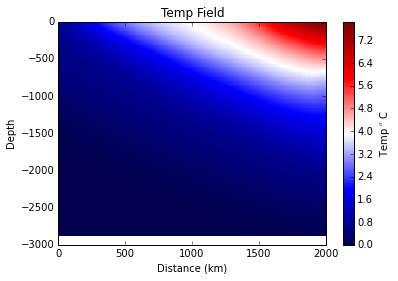

In [18]:
#D=np.linspace(np.nanmin(Densav), np.nanmax(Densav), num=9)
plt.pcolor(Yc,Zexp,Texp,cmap=cm.seismic)
cbar = plt.colorbar()
#cbar = plt.colorbar(ticks=D,format='%0.2f')
plt.title('Temp Field')
plt.xlabel('Distance (km)')
plt.ylabel('Depth')
cbar.ax.set_ylabel('Temp $^o$C')
x="/noc/users/hb1g13/Figures/"+Comp+"/"+OP 
if not os.path.exists(x):
       os.makedirs(x)
#plt.savefig(x+'/TempField.png')

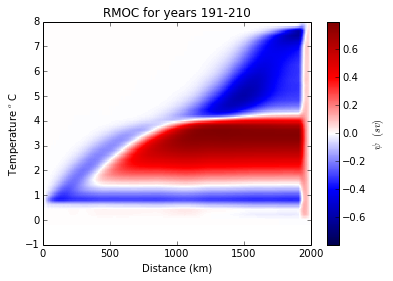

In [19]:
plt.pcolor(y,Rexp,Pexp,cmap=cm.seismic)
cbar = plt.colorbar()
clim((-np.nanmax(abs(psi)),np.nanmax(abs(psi))))
plt.title("RMOC for years "+str(start)+"-"+str(end)+" ")
plt.xlabel('Distance (km)')
plt.ylabel('Temperature $^o$C')
cbar.ax.set_ylabel("$\psi \,\, (sv)$")
#plt.text(1500, 4, r"AAIW", fontsize=17, color="white")
#plt.text(1500, 1.5, r"NADW", fontsize=16, color="white")
#plt.text(1500, 0, r"AABW", fontsize=16, color="white")
x="/noc/users/hb1g13/Figures/"+Comp+"/"+OP
if not os.path.exists(x):
       os.makedirs(x)
plt.savefig(x+"/Psires"+str(start)+"-"+str(end)+"(annotated).png")

In [22]:
Psimap=np.zeros(shape(Texp))

In [20]:
temp=np.zeros(shape(Texp))
for j in range((len(Yc))):
    for k in range((len(Zexp))):
        temp[k,j]=round(Texp[k,j],2)

In [23]:
for i in range(len(Yc)):
    for k in range(168):
        D=Texp[k,i]
        if D==nan:
           Psimap[k,i]=nan
        else:
            P=Pexp[:,i]
            I=find_nearest(Rexp, D)
            b=nonzero(Rexp==I)[0][0]
            Psimap[k,i]=P[b]

In [24]:
plot1=plt.pcolor(Yc,Zexp,Psimap,cmap=cm.seismic)
cbar = plt.colorbar()
clim(-1,1)
plt.title('Remapped Stream Function')
plt.xlabel('Distance (km)')
plt.ylabel('Depth')
cbar.ax.set_ylabel('$\psi_{res}$ (Sv)')
x="/noc/users/hb1g13/Figures/"+Comp+"/"+OP 
if not os.path.exists(x):
       os.makedirs(x)
y=x+"/Reampped"+Years+".png" 
plt.savefig(y)